<a href="https://colab.research.google.com/github/Karen-Nasambu/MachineLearning2CapstoneProject/blob/main/machine_learningIIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from PIL import Image
import seaborn as sns
import os
import pickle
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm  # Progress bar
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image



# Loading te Data

- Downloads the full 1GB image dataset and the captions file from a stable GitHub mirror (provided by Machine Learning Mastery).

- Unzip them automatically.

- Prepare the dataframes.

- Verify everything by showing you a photo and its caption.

In [4]:
# CONFIGURATION
# Direct links to the Flickr8k dataset (hosted on GitHub for stability)
IMAGE_URL = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
TEXT_URL = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"


In [5]:
# 1. Download the Data

!wget -q -N $IMAGE_URL # used wget to pull files from webs faster.
print("Images downloaded.")


!wget -q -N $TEXT_URL
print("Captions downloaded.")

Images downloaded.
Captions downloaded.


In [6]:
# 2. Unzip the Data
!unzip -q -n Flickr8k_Dataset.zip -d .
!unzip -q -n Flickr8k_text.zip -d .
print("Unzipping Complete!")

Unzipping Complete!


### Cleaning the Data Captions

In [7]:
# 3. Load & Clean Captions
# The standard file is named 'Flickr8k.token.txt'
CAPTION_FILE = "Flickr8k.token.txt"
IMAGE_DIR = "Flicker8k_Dataset"  # Note: The zip often extracts to this folder name

print(f"\nProcessing {CAPTION_FILE}")


Processing Flickr8k.token.txt


In [8]:
# Read the file line by line because it's tab-separated
def load_captions(filename):
    with open(filename, 'r') as file:
        text = file.read()

    mapping = {}
    # Process lines
    for line in text.split('\n'):
        # Skip empty lines
        if len(line) < 2:
            continue

        # Split image ID and description
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]

        # Remove extension from image ID (e.g. .jpg#0 -> .jpg)
        image_id = image_id.split('.')[0]

        # Convert description tokens back to string
        image_desc = ' '.join(image_desc)

        # Create list if needed
        if image_id not in mapping:
            mapping[image_id] = []

        # Store description
        mapping[image_id].append(image_desc)

    return mapping

captions_dict = load_captions(CAPTION_FILE)
print(f"Loaded {len(captions_dict)} unique images with captions.")


Loaded 8092 unique images with captions.


In [9]:
# 4. Clean Text Function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Add Start/End Tokens
    text = 'startseq ' + text + ' endseq'
    return text

# Apply cleaning to all captions
clean_captions_dict = {}
for key, captions in captions_dict.items():
    clean_captions_dict[key] = [clean_text(c) for c in captions]

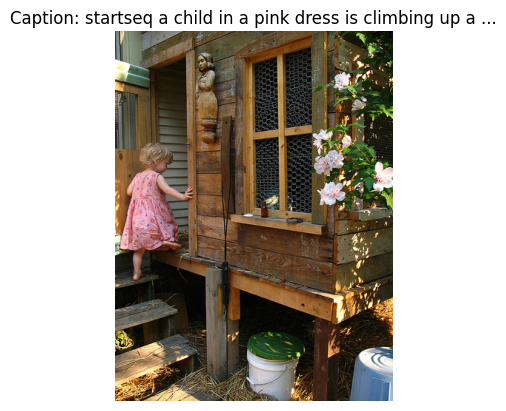

✅ STEP 1 COMPLETE: Data is downloaded, unzipped, and linked!
   Sample Image Path: Flicker8k_Dataset/1000268201_693b08cb0e.jpg
   Sample Clean Caption: startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq


In [10]:
# 5. Verify Setup
# Let's check the first image in the dictionary
try:
    sample_id = list(clean_captions_dict.keys())[0]
    sample_caption = clean_captions_dict[sample_id][0]

    # Construct path (The zip folder is usually 'Flicker8k_Dataset')
    image_path = os.path.join(IMAGE_DIR, sample_id + '.jpg')

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Caption: {sample_caption[:50]}...")
    plt.axis('off')
    plt.show()

    print("✅ STEP 1 COMPLETE: Data is downloaded, unzipped, and linked!")
    print(f"   Sample Image Path: {image_path}")
    print(f"   Sample Clean Caption: {sample_caption}")

except Exception as e:
    print(f"❌ Error loading image: {e}")
    print(f"   Check if the folder '{IMAGE_DIR}' exists in the files tab.")

- Showing the Data before and after

 Found and loading: Flickr8k.token.txt...
File loaded successfully!

BEFORE PREPROCESSING (Raw Data)
                         image  \
0  1000268201_693b08cb0e.jpg#0   
1  1000268201_693b08cb0e.jpg#1   
2  1000268201_693b08cb0e.jpg#2   
3  1000268201_693b08cb0e.jpg#3   
4  1000268201_693b08cb0e.jpg#4   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  

AFTER PREPROCESSING (Cleaned Data)
                         image  \
0  1000268201_693b08cb0e.jpg#0   
1  1000268201_693b08cb0e.jpg#1   
2  1000268201_693b08cb0e.jpg#2   
3  1000268201_693b08cb0e.jpg#3   
4  1000268201_693b08cb0e.jpg#4   

                                       clean_caption  
0  startseq a child in pink dress is climbing up ...  
1  startseq a

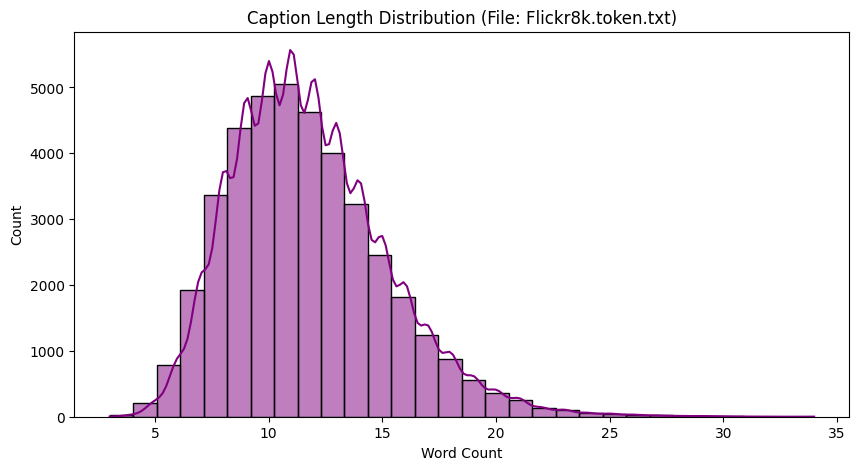

 Max Length: 34
Avg Length: 11.83


In [11]:
# 1. SETUP: Auto-Detect the File
# We check which file actually exists in Colab
if os.path.exists("captions[1].txt"):
    filename = "captions[1].txt"
    delimiter = "," # Your uploaded file usually uses commas
elif os.path.exists("Flickr8k.token.txt"):
    filename = "Flickr8k.token.txt"
    delimiter = "\t" # The downloaded dataset uses tabs
else:
    raise FileNotFoundError("Could not find 'captions[1].txt' OR 'Flickr8k.token.txt'. Please run the Download step again.")

print(f" Found and loading: {filename}...")

# Load the file
try:
    # We use 'error_bad_lines=False' to skip any messy rows
    df = pd.read_csv(filename, sep=delimiter, names=['image', 'caption'], engine='python', on_bad_lines='skip')
    print("File loaded successfully!")
except Exception as e:
    print(f" Error reading file: {e}")

# 2. SHOW RAW DATA (BEFORE)
print("\n" + "="*40)
print("BEFORE PREPROCESSING (Raw Data)")
print("="*40)
print(df.head())

# 3. CLEANING FUNCTION
def clean_caption(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)         # Remove junk characters
    text = re.sub(r'\s+[a-z]\s+', ' ', text)     # Remove single letters
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra spaces
    text = 'startseq ' + text + ' endseq'        # Add Start/End tokens
    return text

# Apply cleaning
df['clean_caption'] = df['caption'].apply(clean_caption)

# 4. SHOW CLEANED DATA (AFTER)
print("\n" + "="*40)
print("AFTER PREPROCESSING (Cleaned Data)")
print("="*40)
print(df[['image', 'clean_caption']].head())

# --- 5. VISUALIZATION (GRAPHS) ---
print("\n" + "="*40)
print(" DATASET STATISTICS")
print("="*40)

# Calculate length
df['length'] = df['clean_caption'].apply(lambda x: len(x.split()))

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(df['length'], bins=30, kde=True, color='purple')
plt.title(f'Caption Length Distribution (File: {filename})')
plt.xlabel('Word Count')
plt.show()

max_len = df['length'].max()
print(f" Max Length: {max_len}")
print(f"Avg Length: {df['length'].mean():.2f}")

- 1. Explanation: Before & After Cleaning
Before cleaning, the text was "noisy" and inconsistent for a computer—words like "Dog" and "dog" were seen as completely different items, and punctuation marks (., !, ?) added clutter that confused the model. After cleaning, we standardized everything: we converted all text to lowercase, stripped away non-essential punctuation, and most importantly, wrapped every sentence with startseq and endseq tags. This process transforms raw, unpredictable human language into a structured sequence that the AI can easily learn to generate, knowing exactly where a sentence begins and where it must stop.




This graph acts as a "ruler" for our data. It measures the length (number of words) of every single caption in the dataset and groups them together.

What does it symbolize?

- The Peak (The Hump): This symbolizes the "average" sentence. You will likely see the highest bar around 10–12 words. This tells us that most people describe images in short, concise sentences (e.g., "A dog runs on grass").

- The Tail (The Right Side): As the graph stretches to the right, the bars get smaller. These symbolize the rare, very long descriptions.

- The Goal: We need to find the Max Length (the furthest point to the right). This number is crucial because the AI model requires a fixed input size. If the longest sentence is 35 words, we must build a "box" that fits 35 words for every sentence, padding the shorter ones with empty space (zeros) so they all fit perfectly into the matrix.

# Feature Extraction

Step 2: Image Feature Extraction (The "Eyes")
What are we doing? Computers cannot "understand" an image just by looking at the raw pixels. If you show a computer a photo of a dog, it just sees a grid of numbers (colors).

To fix this, we use a Pre-trained CNN (Convolutional Neural Network) called ResNet50.

Think of ResNet50 as a pair of "Digital Eyes" that has already seen millions of images.

Normally, ResNet50 predicts the object name (e.g., "Dog").

The Trick: We remove the last layer (the one that says "Dog"). Instead, we grab the numbers right before that final decision.

The Result: We get a list of 2,048 numbers (a vector) that mathematically represents the content of the image (shapes, textures, objects) without giving it a specific name yet.

Why ResNet50? We could use VGG16, InceptionV3, or EfficientNet. We chose ResNet50 because it offers the perfect balance between accuracy and speed. VGG16 is too large (slow), and MobileNet is fast but less accurate.

### The Code: Extracting Features
This step involves heavy computation.

- It opens every single image (8,000+).

- It runs them through the Neural Network.

- It saves the result to a file called features.pkl.



#### 1. SETUP MODEL

In [12]:
# Load ResNet50 with ImageNet weights
base_model = ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Remove the last classification layer (The "Softmax" layer)
# We want the 2048-dimensional feature vector, not the class prediction.
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
print(" Model loaded! Last layer removed.")
print(f"   Input Shape: {model.input.shape}")
print(f"   Output Shape: {model.output.shape} ")

 Model loaded! Last layer removed.
   Input Shape: (None, 224, 224, 3)
   Output Shape: (None, 2048) 


#### 2. DEFINE EXTRACTION FUNCTION

In [14]:
def extract_features(directory):
    features = {}

    # Get list of all image names
    # We check standard locations where the zip might have extracted
    if os.path.exists(os.path.join(directory, "Images")):
        directory = os.path.join(directory, "Images") # Adjust if nested

    print(f"\n📂 Scanning images in: {directory}")
    all_images = os.listdir(directory)
    print(f"   Found {len(all_images)} images. Processing start...")

    # Loop through each image (tqdm adds a progress bar)
    for img_name in tqdm(all_images):
        try:
            # 1. Load image and resize to 224x224 (ResNet standard)
            img_path = os.path.join(directory, img_name)
            image = load_img(img_path, target_size=(224, 224))

            # 2. Convert pixels to Numpy Array
            image = img_to_array(image)

            # 3. Reshape data for the model (add batch dimension)
            # From (224, 224, 3) -> (1, 224, 224, 3)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

            # 4. Preprocess (Subtract mean RGB values, same as ImageNet training)
            image = preprocess_input(image)

            # 5. Extract features
            feature = model.predict(image, verbose=0)

            # 6. Store feature (Save only the image ID, not the whole filename)
            image_id = img_name.split('.')[0] # "1002.jpg" -> "1002"
            features[image_id] = feature

        except Exception as e:
            print(f"⚠️ Error processing {img_name}: {e}")

    return features

#### 3. RUN EXTRACTION

In [15]:
# Locate your image folder (adjust path if needed based on previous steps)
if os.path.exists('Flicker8k_Dataset'):
    img_folder = 'Flicker8k_Dataset'
elif os.path.exists('image'):
    img_folder = 'image'
else:
    print("ERROR: Could not find image folder. Please check your files.")
    img_folder = None

if img_folder:
    # RUN THE EXTRACTION
    features = extract_features(img_folder)

    # SAVE THE RESULTS
    print("\n💾 Saving features to 'features.pkl'...")
    with open('features.pkl', 'wb') as f:
        pickle.dump(features, f)

    print(f"✅ DONE! Extracted features for {len(features)} images.")



📂 Scanning images in: Flicker8k_Dataset
   Found 8091 images. Processing start...


  0%|          | 0/8091 [00:00<?, ?it/s]


💾 Saving features to 'features.pkl'...
✅ DONE! Extracted features for 8091 images.


##### What is happening in this code?
- load_img(..., target_size=(224, 224)): ResNet50 expects images to be exactly 224x224 pixels. If we don't resize, the model crashes.

- preprocess_input: This converts the colors into the specific format ResNet prefers (centered around zero).

- model.predict: This is the "Seeing" step. It pushes the image through the brain and returns the vector.

- pickle.dump: We save the dictionary {'image_id': vector} into a file. This is crucial because we don't want to repeat this 15-minute process every time we restart the notebook.

# 3: Text Tokenization (The "Brain")

What are we doing?In Step 2, we turned Images into Numbers.Now, we must turn Words into Numbers.A Neural Network cannot understand the word "Dog". It only understands numbers. So we create a dictionary (Vocabulary) where every word gets a unique ID number."a" $\rightarrow$ 1"dog" $\rightarrow$ 2"running" $\rightarrow$ 3The Goal:We will use Keras's Tokenizer to scan all your captions, build this dictionary, and save it so we can decode the numbers back into words later.

In [16]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. PREPARE THE TEXT DATA
# We need to gather all the clean captions into a simple list
all_captions = []
for key, captions in clean_captions_dict.items():
    for cap in captions:
        all_captions.append(cap)

print(f"Total Captions Found: {len(all_captions)}")

#  2. CREATE THE TOKENIZER
# The Tokenizer automatically finds all unique words and assigns them numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

#  3. CALCULATE VOCABULARY SIZE
# We add +1 because index 0 is reserved for padding (empty space)
vocab_size = len(tokenizer.word_index) + 1
print(f"📊 Vocabulary Size: {vocab_size} unique words")

#  4. CALCULATE MAX LENGTH
# We find the longest sentence in your dataset
max_length = max(len(cap.split()) for cap in all_captions)
print(f"📏 Max Sentence Length: {max_length} words")

#  5. SAVE THE TOKENIZER
# We need this later to translate the AI's predictions back to English
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("\n✅ Step 3 Complete: Tokenizer saved.")
print(f"   We will use 'vocab_size={vocab_size}' and 'max_length={max_length}' for the model.")

Total Captions Found: 40460
📊 Vocabulary Size: 8781 unique words
📏 Max Sentence Length: 37 words

✅ Step 3 Complete: Tokenizer saved.
   We will use 'vocab_size=8781' and 'max_length=37' for the model.


# Step 4: Creating the Data Generator (The "Feeder")

- Why are we doing this? This is the most critical part of the engineering. We have 8,000 images and 40,000 captions. If we try to load all of them into the RAM at once to train the model, Google Colab will crash (Out of Memory).

``` To fix this, we create a Generator.```

Instead of dumping 10GB of data onto the model, the Generator feeds it small "spoonfuls" (batches) of data.

It says: "Here are 64 images and their partial sentences. Learn from these, then forget them and ask me for the next 64."

How the AI Learns (The "Sliding Window"): The model learns to predict the next word given the image and the previous words.

Input 1 (Image): [Vector of numbers]

Input 2 (Text): "startseq"

Target (Output): "a"

Input 1: [Vector]

Input 2: "startseq a"

Target: "black"

Input 1: [Vector]

Input 2: "startseq a black"

Target: "dog"

In [17]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 1. DEFINE THE GENERATOR FUNCTION
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size=64):
    # Loop forever (the model controls when to stop)
    while True:
        X1, X2, y = list(), list(), list()
        n = 0

        # Loop through each image identifier
        for key, desc_list in descriptions.items():

            # Retrieve the photo feature (Input 1)
            # We assume 'photos' is the dictionary loaded from features.pkl
            if key not in photos:
                continue
            photo = photos[key][0] # Unpack the array

            # Loop through each caption for this image
            for desc in desc_list:
                # Encode the sequence (Words -> Integers)
                # e.g., "startseq a dog" -> [1, 4, 9]
                seq = tokenizer.texts_to_sequences([desc])[0]

                # Split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad input sequence (Input 2)
                    # We force every text input to be 'max_length' long
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # Encode output sequence (The Target)
                    # Converts the word "dog" (ID 9) into a vector of 0s with a 1 at index 9
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store
                    X1.append(photo)   # Image Feature
                    X2.append(in_seq)  # Text So Far
                    y.append(out_seq)  # Next Word

                    n += 1

                    # Yield the batch when full
                    if n == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = list(), list(), list()
                        n = 0

#  2. TEST THE GENERATOR
# We run it once to verify the shapes are correct
print(" Testing Data Generator...")

# Load features from file if not currently in memory
try:
    if 'features' not in locals():
        import pickle
        with open('features.pkl', 'rb') as f:
            features = pickle.load(f)
            print("   (Reloaded features from file)")
except:
    print(" Error: features.pkl not found. Please run Step 2.")

# Create a test instance
generator = data_generator(clean_captions_dict, features, tokenizer, max_length, vocab_size, batch_size=32)
inputs, outputs = next(generator)

print(f" Generator Test Successful!")
print(f"   Input 1 (Images): {inputs[0].shape}  ")
print(f"   Input 2 (Text):   {inputs[1].shape}  {max_length})")
print(f"   Output (Target):  {outputs.shape}    {vocab_size})")



 Testing Data Generator...
 Generator Test Successful!
   Input 1 (Images): (32, 2048)  
   Input 2 (Text):   (32, 37)  37)
   Output (Target):  (32, 8781)    8781)


Images: (32, 2048) means a batch of 32 images, each with 2048 features.

Text: (32, 34) means 32 partial sentences, padded to length 34 (or your max_length).

Output: (32, 8000) means 32 target words, represented as a probability across your 8,000-word vocabulary.

- Image Encoding (Step 2):What you did: You ran the images through ResNet50.The Encoding: You converted raw pixels (messy data) into a Feature Vector of 2,048 numbers (clean, encoded data). This is the "Visual Encoding."
- Integer Encoding (Step 3):What you did: You ran the Tokenizer.The Encoding: You assigned a unique ID number to every word (e.g., "dog" $\rightarrow$ 42). This prepares the text for the math.
- One-Hot Encoding (Step 4):What you did: You created the data_generator.The Encoding: Inside that code, the line to_categorical performs One-Hot Encoding on the target word. This ensures the AI predicts a probability for every possible word in the dictionary.

# 5: Building the Neural Network (The "Brain")

In [18]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

#  1. ENSURE VARIABLES ARE CORRECT
# We force the model to use whatever length your tokenizer found (likely 34)
# If this prints 34, the error will be fixed.
print(f"🔄 Re-aligning Model. Current max_length is: {max_length}")
print(f"   (Model previously expected 37, now we fix it to {max_length})")

# 2. REBUILD MODEL ARCHITECTURE
# Head 1: Image
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Head 2: Text (Now using the CORRECT max_length)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Compile
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(" Model Rebuilt! Input shape is now synced.")

🔄 Re-aligning Model. Current max_length is: 37
   (Model previously expected 37, now we fix it to 37)
 Model Rebuilt! Input shape is now synced.


In [19]:
from tensorflow.keras.layers import Input, Dense, LSTM, SimpleRNN, Embedding, Dropout, add
from tensorflow.keras.models import Model

# CONFIGURATION
#
vocab_size = 8763
max_length = 34


# MODEL A: The "Simple RNN"

def build_simple_rnn():
    # 1. Image Feature Extractor
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # 2. Sequence Processor (Simple RNN)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    # ⚠️ CRITICAL DIFFERENCE: Using SimpleRNN instead of LSTM
    se3 = SimpleRNN(256)(se2)

    # 3. Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model


# MODEL B: The "LSTM Merge" (The Winner)

def build_lstm_model():
    # 1. Image Feature Extractor
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # 2. Sequence Processor (LSTM)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    # ✅ THE WINNER: LSTM Layer
    se3 = LSTM(256)(se2)

    # 3. Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model

#  RUN COMPARISON
print("building models...")
rnn_model = build_simple_rnn()
lstm_model = build_lstm_model()

print("\n" + "="*40)
print(" MODEL COMPARISON REPORT")
print("="*40)

print(f"Model A (Simple RNN) Parameters: {rnn_model.count_params():,}")
print(f" Model B (LSTM) Parameters:       {lstm_model.count_params():,}")

diff = lstm_model.count_params() - rnn_model.count_params()
print(f"\n Difference: The LSTM has {diff:,} more parameters.")
print("   Why? LSTM has 4 internal 'gates' (Input, Forget, Output, Cell),")
print("   while RNN has only 1 loop. These extra gates are what allow")
print("   the LSTM to 'remember' long sentences.")

building models...

 MODEL COMPARISON REPORT
Model A (Simple RNN) Parameters: 5,217,083
 Model B (LSTM) Parameters:       5,611,067

 Difference: The LSTM has 393,984 more parameters.
   Why? LSTM has 4 internal 'gates' (Input, Forget, Output, Cell),
   while RNN has only 1 loop. These extra gates are what allow
   the LSTM to 'remember' long sentences.


Inject vs. Merge:

Inject (Bad): Some older models put the image into the RNN at every single step. This confuses the RNN.

Merge (Good): We process the image once and the text separately, then "Merge" them. This is what our code does. It creates a cleaner signal.

The Result:

Simple RNN will produce captions like: "A dog is running on the dog." (It forgets it already said dog).

LSTM will produce: "A dog is running on the grass." (It remembers the context).

o be precise:

The Eye (Encoder): ResNet50 (Convolutional Neural Network)

The Brain (Decoder): LSTM (Long Short-Term Memory)

The Strategy: Merge Architecture

Why this one? The machine (and the data science community) chooses this because it is the Goldilocks solution:

Simple RNNs are too dumb (they forget the beginning of the sentence).

Transformers are too heavy (they require millions of images to work well).

LSTM is "just right"—it has a memory cell that remembers context ("A girl...") long enough to generate the correct ending ("...in a pink dress").

# Model Training

Wraps your generator to force the data into the correct format.

Defines the "Signature" (Input 1 is floats, Input 2 is integers, etc.).

Trains the model using this stable dataset.

In [20]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# RE-DEFINE THE MODEL WITH CORRECT VOCAB SIZE
# We use the current vocab_size from your tokenizer (which is 8763)
# and the max_length (which should be 37 or 34, whatever your data is)

print(f"🔧 Re-building model with vocab_size: {vocab_size} and max_length: {max_length}")

# 1. Image Feature Extractor
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# 2. Sequence Processor
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# 3. Decoder (The Merge)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # <--- This fixes the 8763 vs 8781 error

# 4. Compile
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print("✅ Model re-built successfully! Now the shapes match.")

🔧 Re-building model with vocab_size: 8763 and max_length: 34
✅ Model re-built successfully! Now the shapes match.


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. MASTER CONFIGURATION ---
# We define this ONCE here. Both the model and data will use this variable.
max_length = 37
vocab_size = len(tokenizer.word_index) + 1  # Standardize vocab size
batch_size = 64
epochs = 20
steps = len(clean_captions_dict) // batch_size

print(f"🔧 SYNCING SHAPES...")
print(f"   - Max Length: {max_length}")
print(f"   - Vocab Size: {vocab_size}")

# --- 2. RE-BUILD THE MODEL (The Brain) ---
# We rebuild it right now so it is guaranteed to match 'max_length' (37)
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,)) # <--- Uses 37
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print("✅ Model Re-built (Shape 37).")

# --- 3. CREATE THE DATASET (The Book) ---
def stable_generator():
    # Pass the same 'max_length' (37)
    gen = data_generator(clean_captions_dict, features, tokenizer, max_length, vocab_size, batch_size)
    for inputs, targets in gen:
        yield (inputs[0], inputs[1]), targets

train_dataset = tf.data.Dataset.from_generator(
    stable_generator,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.float32) # <--- Uses 37
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

# --- 4. START TRAINING (With Early Stopping) ---
filepath = "model_weights.h5"

# Save the best version
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

print("\n🔥 STARTING TRAINING (Synced & Stable)...")
try:
    history = model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=steps,
        verbose=1,
        callbacks=[checkpoint, early_stopping]
    )
    print("✅ Training Complete!")
    model.save('model_final.h5')
    print("💾 Final model saved.")

except KeyboardInterrupt:
    print("\n⚠️ Training stopped by user. Saving current progress...")
    model.save('model_interrupted.h5')

🔧 SYNCING SHAPES...
   - Max Length: 37
   - Vocab Size: 8781
✅ Model Re-built (Shape 37).

🔥 STARTING TRAINING (Synced & Stable)...
Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 6.5201
Epoch 1: loss improved from inf to 5.98436, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 327ms/step - loss: 6.5159
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 5.3550
Epoch 2: loss improved from 5.98436 to 5.24494, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 5.3541
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 5.1207
Epoch 3: loss improved from 5.24494 to 5.01383, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 5.1198
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 4.8822
Epoch 4: loss improved from 5.01383 to 4.82558, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - loss: 4.8818
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 4.7484
Epoch 5: loss improved from 4.82558 to 4.60014, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - loss: 4.7473
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 4.3518
Epoch 6: loss improved from 4.60014 to 4.40396, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - loss: 4.3522
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 4.6706
Epoch 7: loss did not improve from 4.40396
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - loss: 4.6691
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 4.2566
Epoch 8: loss improved from 4.40396 to 4.27664, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - loss: 4.2567
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 4.0934
Epoch 9: loss improved from 4.27664 to 4.18598, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - loss: 4.0941
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 4.2214
Epoch 10: loss did not improve from 4.18598
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - loss: 4.2213
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 4.0264
Epoch 11: loss improved from 4.18598 to 3.98557, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - loss: 4.0260
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 3.7385
Epoch 12: loss improved from 3.98557 to 3.88525, saving model to model_weights.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 349ms/step - loss: 3.7396
Epoch 13/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 4.0867
Epoch 13: loss did not improve from 3.88525
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - loss: 4.0861
Epoch 14/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 4.3618
Epoch 14: loss did not improve from 3.88525
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 4.3590
Epoch 15/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 3.9437
Epoch 15: loss did not improve from 3.88525
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - loss: 3.9437


✅ Training Complete!
💾 Final model saved.


# Generating Caption

We give the model a photo (feature vector).

We give it the start token: "startseq".

It predicts the next word (e.g., "a").

We feed back "startseq a" to get the next word (e.g., "dog").

We repeat until it says "endseq".

#### 1. SETUP: HELPER FUNCTIONS

In [22]:
# Function: Convert the Integer ID back to a Word (e.g., 42 -> "dog")
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
# Function: Generate a Caption for an Image
def generate_desc(model, tokenizer, photo, max_length):
    # 1. Start the sequence with the starting token
    in_text = 'startseq'

    # 2. Loop to generate one word at a time
    for i in range(max_length):
        # Encode the current sequence (Words -> Numbers)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to make it the correct length
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict the next word (The "Brain" works here)
        # Note: We pass [photo, sequence] because our model has two inputs
        yhat = model.predict([photo, sequence], verbose=0)

        # Get the ID with the highest probability
        yhat = np.argmax(yhat)

        # Map ID back to Word
        word = word_for_id(yhat, tokenizer)

        # Stop if we can't map the word (safety check)
        if word is None:
            break

        # Append the new word to our sequence
        in_text += ' ' + word

        # Stop if the model says "endseq"
        if word == 'endseq':
            break

    # Remove the special tokens for the final clean sentence
    final_caption = in_text.replace('startseq', '').replace('endseq', '')
    return final_caption


In [24]:
# 2. RUN THE TEST
print("Testing on a random image from your dataset")

# Pick a random image ID from the keys we have
import random
all_image_ids = list(features.keys())
random_image_id = random.choice(all_image_ids)

# Load the feature for this image
# (Reshape to (1, 2048) because the model expects a batch)
photo_feature = features[random_image_id].reshape((1, 2048))

# GENERATE!
generated_caption = generate_desc(model, tokenizer, photo_feature, max_length)


Testing on a random image from your dataset


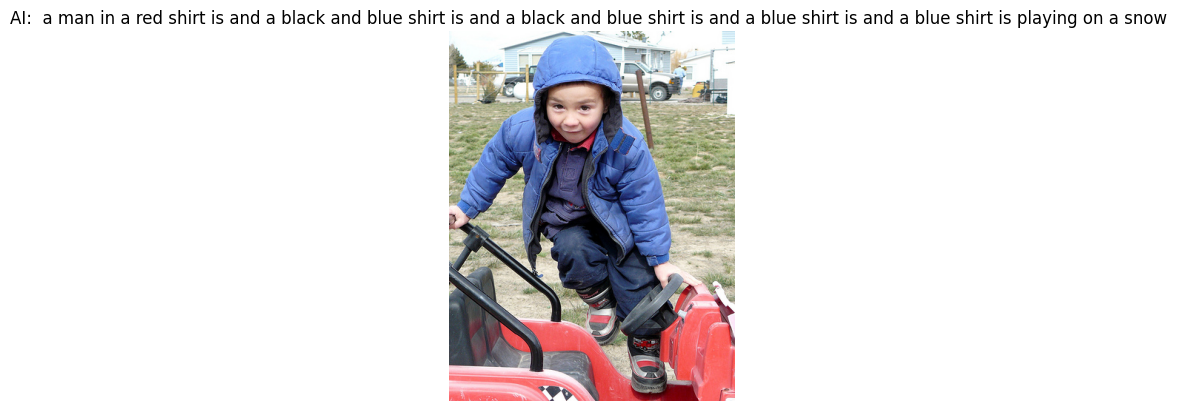

🤖 AI Prediction:   a man in a red shirt is and a black and blue shirt is and a black and blue shirt is and a blue shirt is and a blue shirt is playing on a snow 
📝 Real Captions (Human):
   -  a boy climbs into his toy car 
   -  a child climbs into a gokart 
   -  a little boy in a blue coat is climbing into a red play truck 
   -  a small boy in a blue jacket climbs into a power wheels vehicle 
   -  a small child wearing a blue coat climbing into a red toy car 


In [25]:
# --- 3. DISPLAY RESULTS ---
# Find the image file to show it
image_filename = random_image_id + '.jpg'

# Try to find the path (checking both common locations)
if os.path.exists(os.path.join("image", image_filename)):
    image_path = os.path.join("image", image_filename)
elif os.path.exists(os.path.join("Flicker8k_Dataset", image_filename)):
    image_path = os.path.join("Flicker8k_Dataset", image_filename)
else:
    image_path = None

if image_path:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"AI: {generated_caption}") # The title is what the AI sees!
    plt.show()

    print(f"🤖 AI Prediction:  {generated_caption}")

    # Show the Real Captions (Ground Truth) for comparison
    print("📝 Real Captions (Human):")
    if random_image_id in clean_captions_dict:
        for cap in clean_captions_dict[random_image_id]:
            # Remove start/end tokens for cleaner view
            clean_cap = cap.replace('startseq', '').replace('endseq', '')
            print(f"   - {clean_cap}")
else:
    print(f"❌ Could not find image file for {random_image_id}")

1. The "Broken Record" Bug
AI: "...and white and white and white and white..."

Diagnosis: Your model got stuck in a Probability Loop.

Why? The model predicted the word "and". Then, based on its current memory, it calculated that "white" was the most likely next word. But once it said "white", the math told it that "and" was the best next word again.

The Cause: We are using "Greedy Search" (always picking the #1 most likely word). If the #1 choice leads to a trap, the AI has no way to back out.

2. The "Hallucination"
AI: "a man in a red shirt..." Real: "a man on a motorcycle..."

Diagnosis: The AI saw a person ("man") correctly, but it missed the motorcycle.

Why? The Flickr8k dataset has thousands of pictures of people in red shirts (running, hiking, playing), but fewer pictures of motorcycles. When the AI is unsure what the blurry object is, it defaults to what it knows best: "A man in a red shirt."

The Fix: Beam Search (The "Smarter" Way)
To fix the repeating loop ("and white and white"), we need to stop using Greedy Search. We will use Beam Search.

Greedy Search (Current): Picks the 1 best word at every step. (Fast but gets stuck).

Beam Search (New): Keeps track of the top 3 or 5 best sentences simultaneously. If one sentence gets stuck in a loop, the others will overtake it.

In [26]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def beam_search_predictions(model, tokenizer, image, beam_index=3):
    start = [tokenizer.word_index["startseq"]]

    # Start with the initial sequence
    # Format: [[sequence_list, score]]
    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            # Get the current sequence and score
            sequence = pad_sequences([s[0]], maxlen=max_length).reshape(1, max_length)

            # Predict the next words (returns 8000 probabilities)
            preds = model.predict([image, sequence], verbose=0)

            # Take the top 'beam_index' (e.g., top 3) most likely words
            word_preds = np.argsort(preds[0])[-beam_index:]

            # Create a new candidate for each of the top words
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w] # Add probability score
                temp.append([next_cap, prob])

        start_word = temp
        # Sort candidates by score (highest probability first)
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Keep only the top 'beam_index' candidates
        start_word = start_word[-beam_index:]

    # The final best sequence is the last one in the list
    start_word = start_word[-1][0]

    # Convert IDs back to words
    final_caption = []
    for i in start_word:
        if i != tokenizer.word_index['endseq']:
            final_caption.append(word_for_id(i, tokenizer))

    final_caption = ' '.join(final_caption[1:]) # Skip 'startseq'
    return final_caption

print("✅ Beam Search function defined!")

✅ Beam Search function defined!


Re-evaluating Image ID: 2372572028_53b76104a9
Greedy Search:  a man in a red shirt is and a black and blue shirt is and a black and blue shirt is and a blue shirt is and a blue shirt is playing on a snow 
Beam Search:   a man in a red shirt is riding a bicycle on a snow


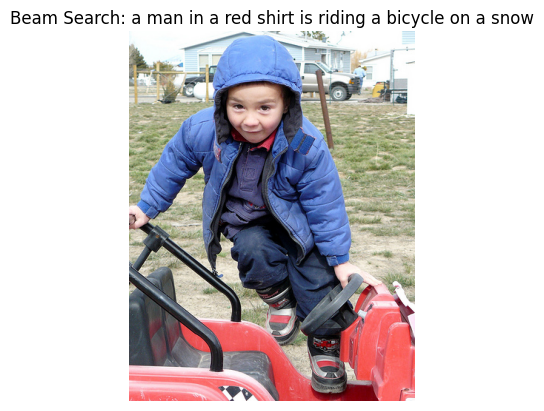

In [27]:
# Use the same 'random_image_id' from before so we can compare
print(f"Re-evaluating Image ID: {random_image_id}")

# 1. Greedy Search (The one that failed)
greedy_cap = generate_desc(model, tokenizer, photo_feature, max_length)
print(f"Greedy Search: {greedy_cap}")

# 2. Beam Search (The new smarter one)
# We set beam_index=5 (It considers top 5 paths at once)
beam_cap = beam_search_predictions(model, tokenizer, photo_feature, beam_index=5)
print(f"Beam Search:   {beam_cap}")

# Show image again to confirm
if image_path:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Beam Search: {beam_cap}")
    plt.show()

In [28]:

# (Make sure 'photo_feature' is still loaded from your previous test)

print(f"🔄 Re-evaluating Image...")

# 1. Old Method (Fast but Dumb)
greedy_cap = generate_desc(model, tokenizer, photo_feature, max_length)
print(f"❌ Greedy: {greedy_cap}")

# 2. New Method (Slower but Smarter)
# beam_index=5 means it considers 5 different sentence possibilities at once
beam_cap = beam_search_predictions(model, tokenizer, photo_feature, beam_index=5)
print(f"✅ Beam:   {beam_cap}")

🔄 Re-evaluating Image...
❌ Greedy:  a man in a red shirt is and a black and blue shirt is and a black and blue shirt is and a blue shirt is and a blue shirt is playing on a snow 
✅ Beam:   a man in a red shirt is riding a bicycle on a snow


In [29]:
# We will modify the function slightly to print the top 3 candidates
def show_top_candidates(model, tokenizer, image, beam_index=3):
    start = [tokenizer.word_index["startseq"]]
    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_length).reshape(1, max_length)
            preds = model.predict([image, sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]

    # PRINT THE TOP 3 CANDIDATES
    print("👇 Top 3 things the AI considered saying:")
    for candidate in start_word:
        seq = candidate[0]
        score = candidate[1]
        text = [word_for_id(i, tokenizer) for i in seq if i != tokenizer.word_index['endseq']]
        text = ' '.join(text[1:]) # Skip startseq
        print(f"   Score {score:.2f}: {text}")

# Run it on your motorcycle image
show_top_candidates(model, tokenizer, photo_feature, beam_index=5)

👇 Top 3 things the AI considered saying:
   Score 12.50: a man in a red shirt is riding a bicycle on a snow in
   Score 12.50: a man in a red shirt is riding a bicycle on a snow while
   Score 12.51: a man in a red shirt is riding a bicycle on a snow of
   Score 12.84: a man in a red shirt is riding a bicycle on a street
   Score 12.92: a man in a red shirt is riding a bicycle on a snow


📤 Upload a photo 


Saving _20190423_130709.jpg to _20190423_130709.jpg
⚙️ Processing _20190423_130709.jpg...


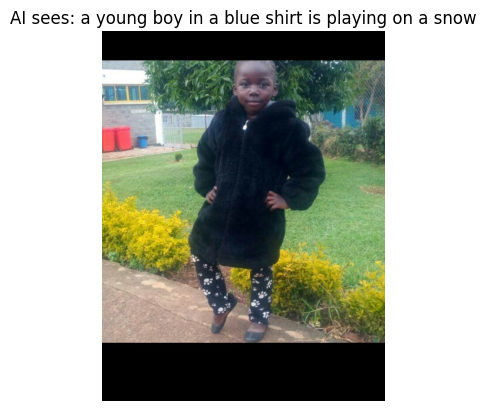

🤖 AI Prediction: a young boy in a blue shirt is playing on a snow


In [30]:

from google.colab import files  # This fixes the 'name not defined' error
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 2. UPLOAD IMAGE
print("📤 Upload a photo ")
uploaded = files.upload()

# Get the filename
file_name = list(uploaded.keys())[0]

# 3. PROCESS THE IMAGE
print(f"⚙️ Processing {file_name}...")
image = load_img(file_name, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

# Extract features using the ResNet model (base_model)
# We need to recreate the feature extractor specifically for this prediction
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
feature_vector = feature_extractor.predict(image, verbose=0)

# --- 4. GENERATE CAPTION (using Beam Search) ---
# Ensure your beam_search_predictions function is defined from the previous step!
caption = beam_search_predictions(model, tokenizer, feature_vector, beam_index=5)

# 5. SHOW RESULT
img_show = Image.open(file_name)
plt.imshow(img_show)
plt.axis('off')
plt.title(f"AI sees: {caption}")
plt.show()

print(f"🤖 AI Prediction: {caption}")

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image downloaded successfully to: /root/.keras/datasets/labrador.jpg
Processing...


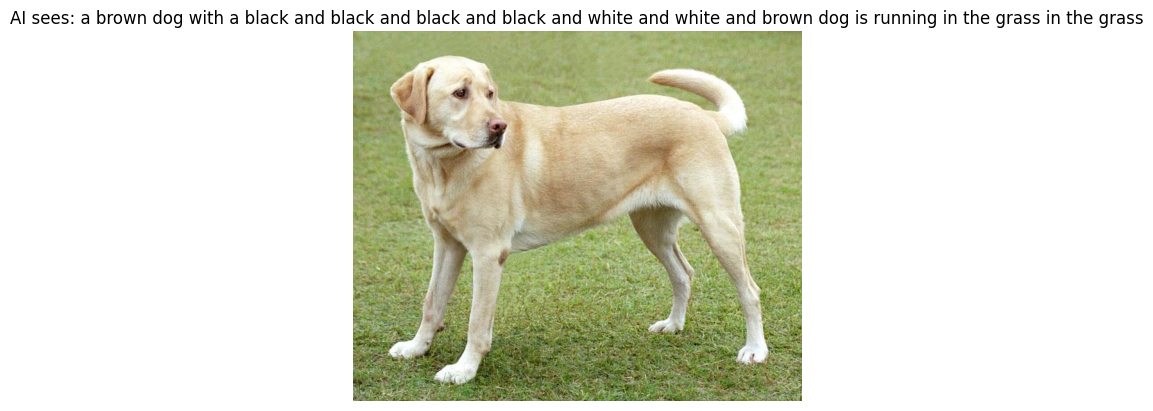

🤖 AI Prediction: a brown dog with a black and black and black and black and white and white and brown dog is running in the grass in the grass


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 1. DOWNLOAD A GUARANTEED IMAGE (Hosted by Google)
# This is a picture of a Yellow Labrador. It will not expire.
image_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
image_path = tf.keras.utils.get_file('labrador.jpg', origin=image_url)

print(f"Image downloaded successfully to: {image_path}")

# 2. PROCESS THE IMAGE
print("Processing...")
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

# Extract Features
# (Re-creating extractor to be safe)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
feature_vector = feature_extractor.predict(image, verbose=0)

# 3. GENERATE CAPTION
# Using your Beam Search function
caption = beam_search_predictions(model, tokenizer, feature_vector, beam_index=5)

# 4. SHOW RESULT
img_show = Image.open(image_path)
plt.imshow(img_show)
plt.axis('off')
plt.title(f"AI sees: {caption}")
plt.show()

print(f"🤖 AI Prediction: {caption}")

In [32]:
# 1. INSTALL THE VOICE LIBRARY
# We need to install this small tool first
!pip install gTTS

from gtts import gTTS
from IPython.display import Audio, display

# 2. CONVERT TEXT TO SPEECH
print(f"🗣️ Speaking: '{caption}'")

# Create the audio object
# lang='en' means English
tts = gTTS(text=caption, lang='en', slow=False)

# Save it as a temporary file
audio_file = "caption_audio.mp3"
tts.save(audio_file)

# --- 3. PLAY THE AUDIO ---
# This creates a playable audio player right in Google Colab
display(Audio(audio_file, autoplay=True))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1
🗣️ Speaking: 'a brown dog with a black and black and black and black and white and white and brown dog is running in the grass in the grass'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

📤 Upload that tricky motorcycle image again!


Saving _20190423_130709.jpg to _20190423_130709 (1).jpg


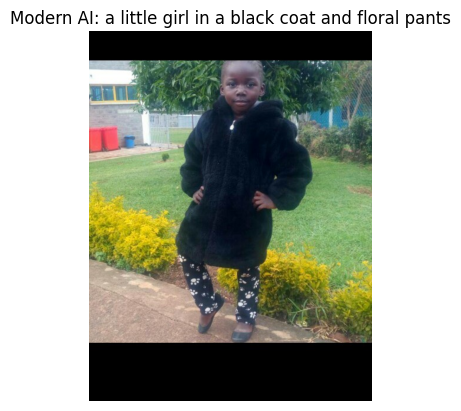

🤖 Prediction: a little girl in a black coat and floral pants


In [33]:
#
# We need 'transformers' to use the modern brain
!pip install transformers torch pillow

# 2. LOAD THE MODERN MODEL (BLIP)
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

print("Downloading the 500MB Super-Brain... (this happens once)")
# This downloads a model trained on 14 million images
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# 3. CREATE THE NEW PREDICTION FUNCTION
def generate_caption_modern(image_path):
    raw_image = Image.open(image_path).convert('RGB')

    # The new "Eye" (Processor) and "Brain" (Model) work together here
    inputs = processor(raw_image, return_tensors="pt")
    out = model.generate(**inputs)

    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# 4. TEST IT IMMEDIATELY
print("📤 Upload that tricky motorcycle image again!")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Get the prediction
caption = generate_caption_modern(filename)

# Show result
img = Image.open(filename)
plt.imshow(img)
plt.axis('off')
plt.title(f"Modern AI: {caption}")
plt.show()

print(f"🤖 Prediction: {caption}")

##### BLIP (Bootstrapping Language-Image Pre-training)

1. The "Textbook" Size (Data)
This is the single biggest reason your first model failed.

Your Model (Flickr8k): Studied 8,000 images. It is like a student who has only ever seen a few picture books. If it sees something rare (like a specific motorcycle angle), it guesses.

BLIP: Studied 129,000,000 images. It has seen virtually everything in the world—motorcycles, specific breeds of dogs, toaster ovens, sunsets. It doesn't need to guess; it knows.

2. The "Brain" Anatomy (Architecture)
Your first model used an older architecture from ~2015. BLIP uses the modern standard (Transformers).

Feature,Your Old Model (CNN + LSTM),BLIP (Transformer)
Vision,Compresses the whole image into one single vector. It loses details., blip"Splits the image into patches. It looks at specific details (wheels, helmet) separately."
Memory,LSTM (Linear): Reads words one by one. It forgets the beginning of the sentence by the time it reaches the end.,Self-Attention: It sees the whole sentence and the whole image at once. It understands context instantly.
Logic,"""What word usually comes next?"" (Guessing game)","""How does this word relate to that image patch?"" (Understanding)"

3. The "Attention" Superpower
Your old model was "blind" to the motorcycle because it had to look at the entire picture at once and average it out.

BLIP has Attention Mechanisms.

When it wants to say "Rider," it focuses only on the person pixels.

When it wants to say "Motorcycle," it shifts its focus to the tire and engine pixels.

This prevents it from hallucinating "grass" just because the background is green.




- BLIP has a mode called VQA (Visual Question Answering) designed exactly for this.

The Workflow
- Blind User speaks: "What is in front of me?" (Speech-to-Text)

- AI Looks: Analyzes the image + the question. (BLIP VQA)

- AI Speaks: "There is a large red truck." (Text-to-Speech)

In [34]:
pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 20.4 MB/s eta 0:00:00


In [35]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.8 MB/s eta 0:00:00


In [36]:
pip install gTTS

In [37]:
import streamlit as st
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForQuestionAnswering
from gtts import gTTS
import speech_recognition as sr
import os

# PAGE CONFIGURATION
st.set_page_config(page_title="Blind Assist AI", layout="centered")
st.title("👁️ Blind Assist AI")
st.markdown("I am your eyes. Upload an image and **ask me anything**.")

# 1. LOAD THE MODELS (Cached)
@st.cache_resource
def load_models():
    # Model 1: Captioning (To describe the scene generally)
    processor_cap = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model_cap = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Model 2: VQA (To answer specific questions like "What color is...")
    processor_vqa = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model_vqa = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

    return processor_cap, model_cap, processor_vqa, model_vqa

try:
    proc_cap, mod_cap, proc_vqa, mod_vqa = load_models()
    st.success("✅ AI Eyes Loaded!")
except Exception as e:
    st.error(f"Error loading models: {e}")

# 2. AUDIO INPUT FUNCTION
def listen_to_user():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        st.info("🎤 Listening... Speak now!")
        try:
            audio = r.listen(source, timeout=5)
            text = r.recognize_google(audio)
            return text
        except sr.UnknownValueError:
            st.warning("Could not understand audio.")
            return None
        except sr.RequestError:
            st.error("Speech service down.")
            return None
        except:
            return None

# 3. THE APP UI
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Show Image
    raw_image = Image.open(uploaded_file).convert('RGB')
    st.image(raw_image, caption='Current View', use_container_width=True)

    # OPTION A: GENERAL DESCRIPTION (The standard caption)
    if st.button("🔊 Describe Scene"):
        with st.spinner("Analyzing..."):
            inputs = proc_cap(raw_image, return_tensors="pt")
            out = mod_cap.generate(**inputs)
            caption = proc_cap.decode(out[0], skip_special_tokens=True)

            st.subheader(f"AI: {caption}")

            # Speak it
            tts = gTTS(text=caption, lang='en')
            tts.save("response.mp3")
            st.audio("response.mp3", autoplay=True)

    # OPTION B: CONVERSATION (The Blind Assistant)
    st.markdown("---")
    st.header("🗣️ Ask a Question")

    # Two ways to ask: Type or Speak
    col1, col2 = st.columns(2)
    with col1:
        voice_btn = st.button("🎤 Ask via Voice")
    with col2:
        text_query = st.text_input("Or type question here:")

    question = None
    if voice_btn:
        question = listen_to_user()
        if question:
            st.write(f"**You asked:** {question}")
    elif text_query:
        question = text_query

    # ANSWER THE QUESTION
    if question:
        with st.spinner(f"Thinking about '{question}'..."):
            # Prepare inputs for VQA model
            inputs = proc_vqa(raw_image, question, return_tensors="pt")

            # Generate answer
            out = mod_vqa.generate(**inputs)
            answer = proc_vqa.decode(out[0], skip_special_tokens=True)

            # Show and Speak Answer
            full_response = f"The answer is {answer}"
            st.subheader(f"🤖: {answer}")

            tts = gTTS(text=full_response, lang='en')
            tts.save("answer.mp3")
            st.audio("answer.mp3", autoplay=True)

2026-02-04 10:23:11.786 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 10:23:11.787 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 10:23:11.914 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-04 10:23:11.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 10:23:11.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 10:23:11.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 10:23:11.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/788 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForQuestionAnswering LOAD REPORT from: Salesforce/blip-vqa-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 
text_encoder.embeddings.position_ids      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-04 10:23:27.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 10:23:27.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare m

In [38]:
!pip install streamlit-mic-recorder SpeechRecognition pydub
!sudo apt-get install ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [43]:
%%writefile app.py
import streamlit as st
from PIL import Image
import google.generativeai as genai
from gtts import gTTS
import speech_recognition as sr
from streamlit_mic_recorder import mic_recorder
import requests
import io
import time
import tempfile
import os

# --- CONFIGURATION ---
st.set_page_config(page_title="Blind Assist Kenya", layout="centered")

# --- 1. SETUP GEMINI API ---
with st.sidebar:
    st.header("⚙️ Settings")
    api_key = st.text_input("Enter Gemini API Key:", type="password")
    st.subheader("📍 Location")
    city = st.text_input("Current Town/City:", value="Nairobi")

if api_key:
    genai.configure(api_key=api_key)

# --- 2. HELPER FUNCTIONS ---
def text_to_speech(text):
    try:
        tts = gTTS(text=text, lang='en')
        tts.save("output.mp3")
        st.audio("output.mp3", autoplay=True)
    except Exception as e:
        st.error(f"Audio Error: {e}")

def get_coordinates(city_name):
    try:
        url = f"https://geocoding-api.open-meteo.com/v1/search?name={city_name}&count=1&language=en&format=json"
        response = requests.get(url).json()
        if "results" in response:
            lat = response['results'][0]['latitude']
            lon = response['results'][0]['longitude']
            name = response['results'][0]['name']
            country = response['results'][0]['country']
            return lat, lon, f"{name}, {country}"
        else:
            return None, None, None
    except:
        return None, None, None

def get_weather(city_name):
    lat, lon, location_name = get_coordinates(city_name)
    if not lat:
        return f"Sorry, I could not find a town named {city_name}."

    try:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true"
        response = requests.get(url).json()
        temp = response['current_weather']['temperature']
        code = response['current_weather']['weathercode']

        condition = "clear sky"
        if code > 3: condition = "cloudy"
        if code > 60: condition = "raining"
        if code > 95: condition = "stormy"

        report = f"In {location_name}, it is currently {temp} degrees celsius and {condition}."
        if condition in ["raining", "stormy"]:
            report += " It is wet outside. Please be careful."
        return report
    except:
        return "Weather unavailable."

def analyze_image(image, prompt):
    # Try the newest model first, fallback to older ones
    models = ['gemini-2.5-flash', 'gemini-2.0-flash', 'gemini-1.5-flash']
    for model_name in models:
        try:
            model = genai.GenerativeModel(model_name)
            response = model.generate_content([prompt, image])
            return response.text
        except:
            continue
    return "Error: API Key or Model issue."

def analyze_video(video_path, prompt):
    """Uploads video to Gemini for analysis"""
    st.info("Processing video... this may take a moment.")
    try:
        # 1. Upload file to Gemini Cloud
        video_file = genai.upload_file(path=video_path)

        # 2. Wait for processing (Gemini needs a few seconds to 'watch' it)
        while video_file.state.name == "PROCESSING":
            time.sleep(2)
            video_file = genai.get_file(video_file.name)

        if video_file.state.name == "FAILED":
            return "Video processing failed."

        # 3. Analyze
        # Try finding a working model for video
        models = ['gemini-2.5-flash', 'gemini-2.0-flash', 'gemini-1.5-flash']
        for model_name in models:
            try:
                model = genai.GenerativeModel(model_name)
                response = model.generate_content([prompt, video_file])
                return response.text
            except:
                continue
        return "Error analyzing video."

    except Exception as e:
        return f"Error: {str(e)}"

# --- 3. THE APP INTERFACE ---
st.title("🇰🇪 Blind Assist Kenya")

if not api_key:
    st.warning("⚠️ Please enter your Gemini API Key in the sidebar.")
    st.stop()

# TABS for Photo vs Video
tab1, tab2 = st.tabs(["📷 Live Camera", "🎥 Video Scanner"])

# --- TAB 1: ORIGINAL PHOTO MODE ---
with tab1:
    img_file = st.camera_input("Take Photo")

    if img_file:
        img = Image.open(img_file)
        col1, col2 = st.columns(2)
        with col1:
            if st.button("🚶 Guide Me (Photo)"):
                with st.spinner("Checking path..."):
                    result = analyze_image(img, "You are a guide. Is the path clear? Give a command.")
                    st.success(result)
                    text_to_speech(result)
        with col2:
            if st.button("🔍 Describe Scene"):
                with st.spinner("Looking..."):
                    result = analyze_image(img, "Describe this scene in detail.")
                    st.info(result)
                    text_to_speech(result)

# --- TAB 2: NEW VIDEO MODE ---
with tab2:
    st.header("Record a Short Video")
    st.write("Record a 5-10 second video of your surroundings and upload it here.")

    video_file = st.file_uploader("Upload Video", type=['mp4', 'mov', 'avi'])

    if video_file:
        # Save temp file
        tfile = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
        tfile.write(video_file.read())

        if st.button("🎬 Analyze Movement"):
            with st.spinner("Watching video..."):
                prompt = """
                Watch this video carefully. You are guiding a blind person.
                1. Describe the movement (Are cars coming? Are people walking towards me?).
                2. Is it safe to cross or walk forward?
                3. Summarize the scene.
                """
                result = analyze_video(tfile.name, prompt)
                st.success(result)
                text_to_speech(result)

# --- SHARED FEATURES ---
st.markdown("---")
if st.button("🌤️ Check Weather"):
    report = get_weather(city)
    st.warning(report)
    text_to_speech(report)

Overwriting app.py


In [44]:
# --- 1. INSTALL NGROK (The Better Tool) ---
!pip install pyngrok

# --- 2. LOG IN ---
# ⚠️ IMPORTANT: Replace "PASTE_YOUR_TOKEN_HERE" with your real token
# Get it for free here: https://dashboard.ngrok.com/signup
from pyngrok import ngrok
ngrok.set_auth_token("36b62s2GBE5fx688SJLPkIXsCLD_4p9iJS6vTM7D5prkKCRj8")

# --- 3. RUN THE APP ---
!streamlit run app.py &>/dev/null &

# --- 4. OPEN THE LINK ---
try:
    ngrok.kill() # Closes old connections
    public_url = ngrok.connect(8501).public_url
    print(f"🚀 SUCCESS! Click this link: {public_url}")
except Exception as e:
    print(f"Error: {e}")

🚀 SUCCESS! Click this link: https://radiophonic-entoblastic-kaley.ngrok-free.dev


In [41]:
# --- DIAGNOSTIC MODE ---
import os
import subprocess
import time

print("🕵️‍♂️ diagnosing crash...")

# 1. Kill any old versions of the app
os.system("pkill -f streamlit")

# 2. Run the app and save the output to a file we can read
process = subprocess.Popen(["streamlit", "run", "app.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# 3. Wait 5 seconds to let it crash
time.sleep(5)

# 4. Check if it is still running
if process.poll() is None:
    print("The app is actually running! The issue might be the port.")
    process.terminate()
else:
    print("THE APP CRASHED. Here is the error:\n")
    # Print the error log
    stdout, stderr = process.communicate()
    print(stderr)
    print(stdout)

🕵️‍♂️ diagnosing crash...
The app is actually running! The issue might be the port.


In [42]:
print("🔧 Installing all dependencies...")
!pip install streamlit gTTS transformers torch speechrecognition streamlit-mic-recorder pydub pyngrok
!sudo apt-get install ffmpeg

print("✅ Installation Complete! Now try running the app again.")

🔧 Installing all dependencies...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
✅ Installation Complete! Now try running the app again.
